In [1]:
import numpy as np
from scipy.constants import *
from pySLM import *
import pySLM
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
%matplotlib  inline

In [2]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['font.size'] = 20

In [3]:
p=8

dmds = [DLP9500(399 * nano, 728 * milli, p,- np.pi / 4) for _ in range(5)]
dmd_grey, dmd_simple, dmd_prob, dmd_ed, dmd_ifta = dmds
sims = [DMDSimulation(dmd, padding=0) for dmd in dmds]
sim_grey, sim_simple, sim_prob, sim_ed, sim_ifta = sims

origin_x = np.cos(dmd_grey.theta)*1920/p
origin_y = np.sin(dmd_grey.theta)*1080/p

In [4]:
method = ["grey scale", "deterministic", "random", "error diffusion", "IFTA"]

In [5]:
input_profile = GaussianTEM(0,0,1,5*milli)*Zernike(50,20*milli, 2,0)
output_profile = ProfileSum([GaussianTEM(450*micro-150*micro*k,0, 1j, 40*micro)\
                          for k in range(6) if k!=1])


signal_profile = copy.deepcopy(output_profile)
for i in signal_profile.profiles:
    i.w = 2*i.w
xc, yc = sim_ifta.first_order_origin
#signal_window = signal_profile.translate(xc , yc) + signal_profile.translate(xc , yc).inverse()
signal_window = signal_profile.translate(xc , yc).inverse() + signal_profile.translate(-xc , -yc).inverse()
#signal_window = signal_profile.translate(xc , yc).inverse()
signal_window2 = RectWindow(xc,yc,1200*micro,50*micro) #+ RectWindow(-xc,-yc,1200*micro,400*micro)


signal_window = signal_window(*dmd_ifta.image_plane_grid)
signal_window2 = signal_window2(*dmd_ifta.image_plane_grid)
signal_window = signal_window > signal_window.max()*0.001

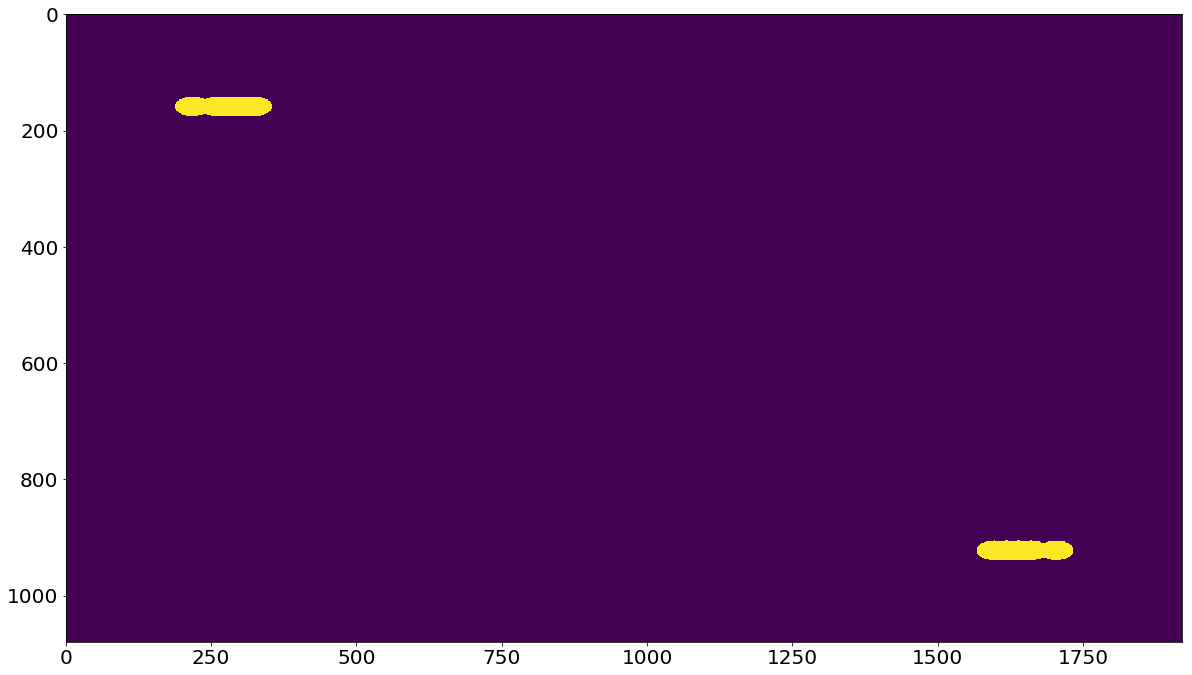

In [6]:
plt.imshow(signal_window)

In [7]:
signal_window3 = output_profile + GaussianTEM(450*micro-150*micro*1,0, 1, 40*micro)
signal_window3 = signal_window3.translate(xc , yc) #+ signal_window3.translate(xc , yc).inverse()
signal_window3 = signal_window3(*dmd_ifta.image_plane_grid)
signal_window3 = signal_window3 / np.max(signal_window3)


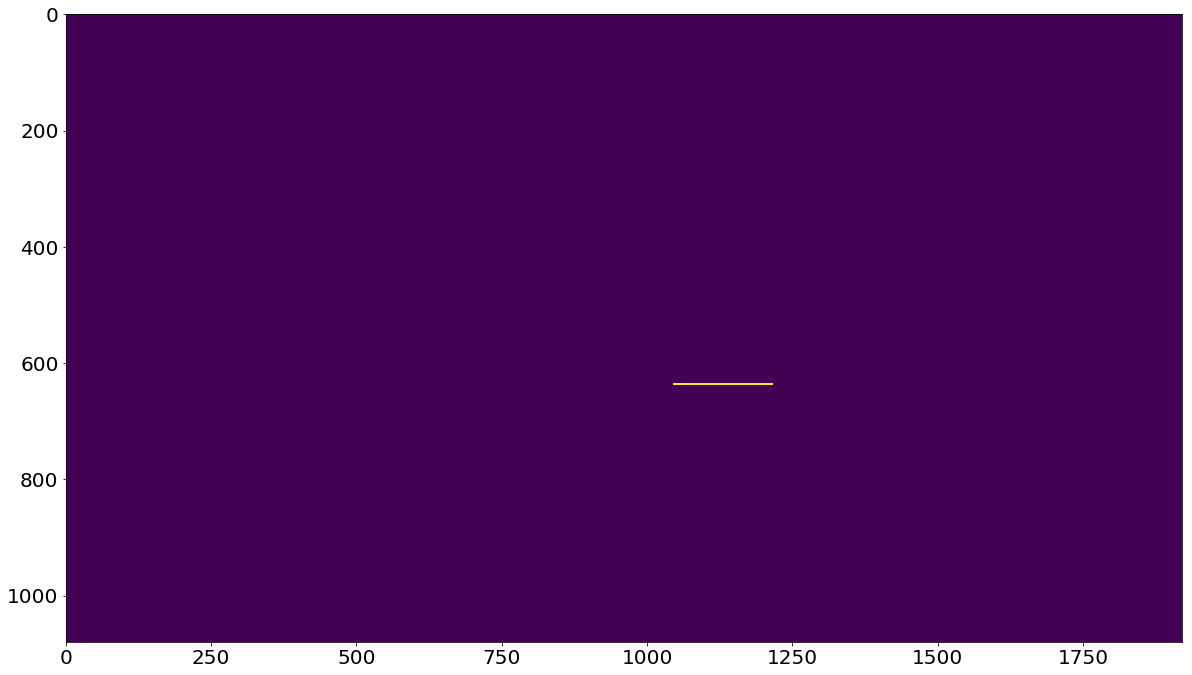

In [8]:
plt.imshow(signal_window2)


In [8]:
dmd_grey.calculate_dmd_state(input_profile, output_profile, binarize=False)

In [ ]:
dmd_simple.calculate_dmd_state(input_profile, output_profile, 
                               binarize=True, binarize_method="simple")

In [ ]:
dmd_prob.calculate_dmd_state(input_profile, output_profile, 
                               binarize=True, binarize_method="random")

In [ ]:
dmd_ed.calculate_dmd_state(input_profile, output_profile, 
                               binarize=True, binarize_method="error_diffusion")

In [ ]:
%load_ext line_profiler

In [ ]:
def run():
    dmd_ifta.calculate_dmd_state(input_profile, output_profile, 
                               binarize=True, binarize_method="IFTA", 
                               signal_window=signal_window2, N=1000,S=1, balance=False,
                                 full_field=True)
%lprun -f pySLM._lib._binzrize_patch_state_IFTA run()


In [12]:
for sim in sims:
    sim.propagate_to_image(input_profile)
    sim.block_zeroth_order()

/home/gilbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/gilbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10
/home/gilbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10


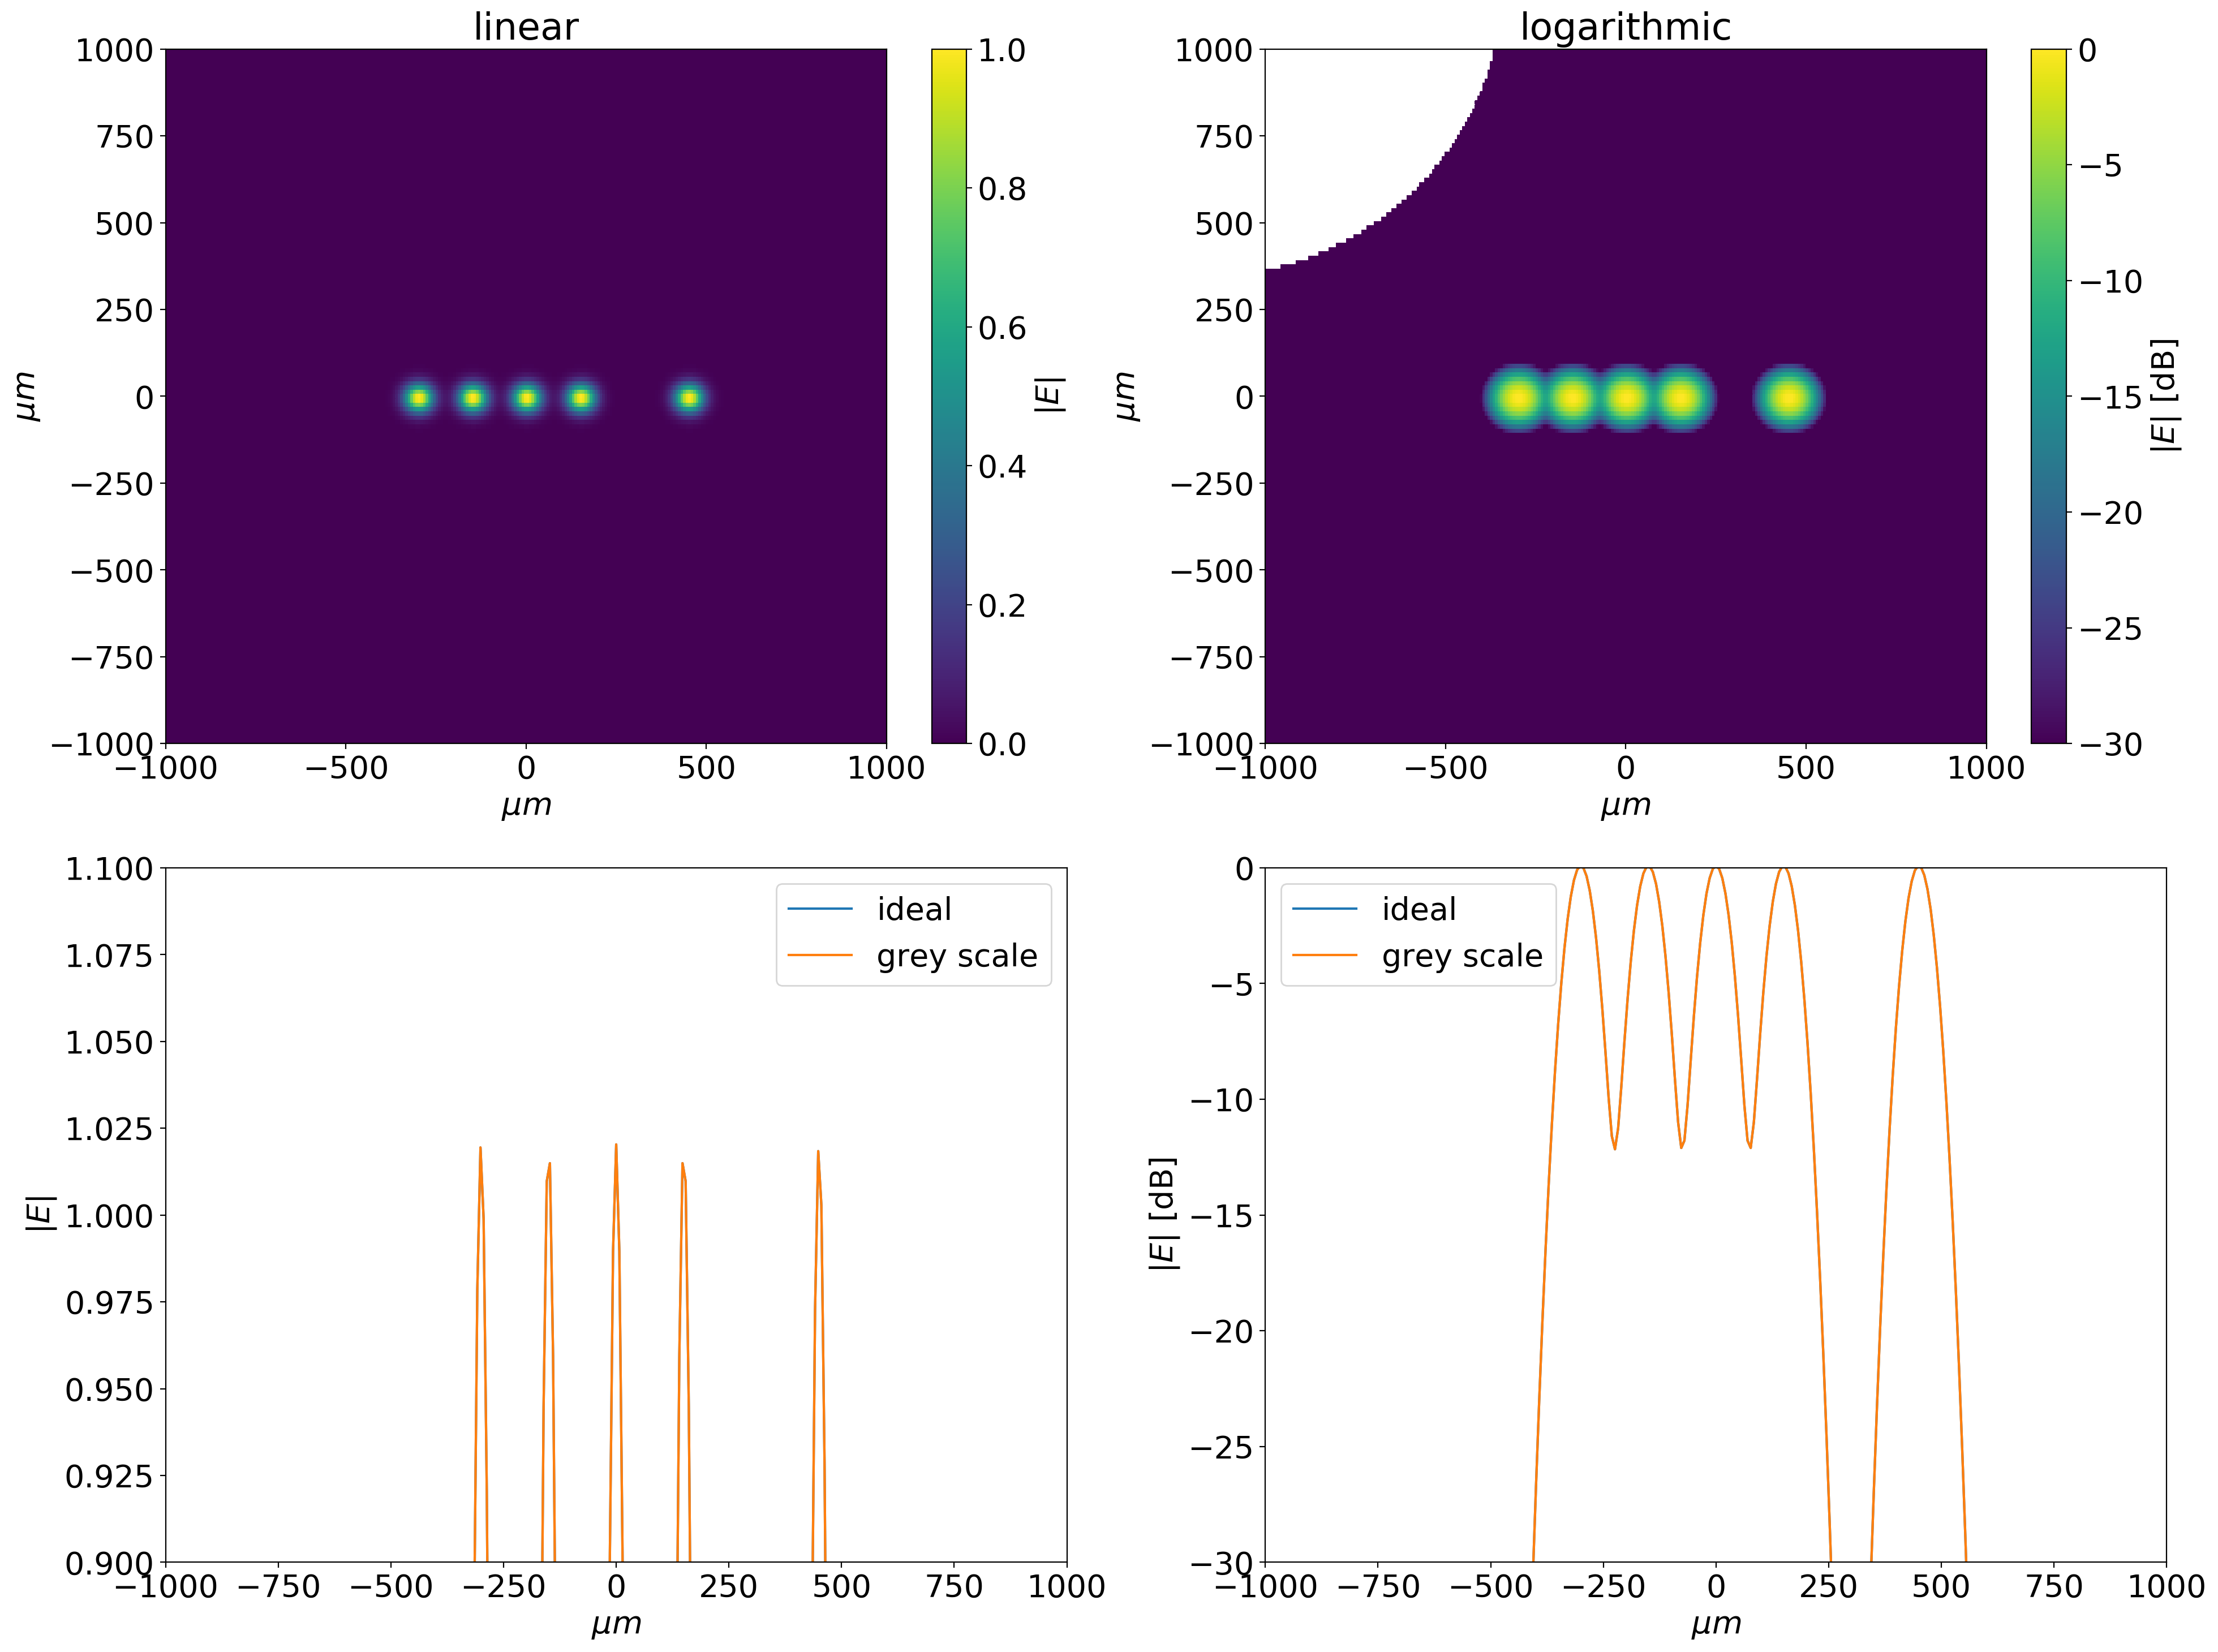

In [13]:
profile_ideal = None

xc, yc = sim_grey.first_order_origin
#xc, yc = -xc, -yc
x_1d = sim_grey.xx_a[0]/micro
xx,yy = (sim_grey.xx_a-xc)/micro, (sim_grey.yy_a-yc)/micro
for i, sim in enumerate(sims):
    field_amp = np.abs(sim.image_plane_field)
    field_amp = field_amp/ np.amax(field_amp)
    field_amp_log = 10*np.log10(field_amp)
    profile_1d = shift(field_amp,(origin_y, -origin_x))[1080//2]#[1920//2-100:1920//2+100]
    
    if i == 0:
        profile_ideal = profile_1d
    if i ==1:
        continue
    if i==2:
        continue
    if i==3:
        continue
    
    
    plt.figure(figsize=(20,15), dpi=200)
    plt.subplot("221")
    plt.title("linear")
    plt.pcolormesh(xx,yy,field_amp)
    plt.xlim(-1000, 1000)
    plt.ylim(-1000, 1000)
    plt.xlabel(r"$\mu m$")
    plt.ylabel(r"$\mu m$")

    plt.colorbar().set_label(r"$|E|$")
    
    plt.subplot("222")
    plt.title("logarithmic")
    plt.pcolormesh(xx,yy,field_amp_log)
    
    plt.xlim(-1000, 1000)
    plt.ylim(-1000,1000)
    plt.xlabel(r"$\mu m$")
    plt.ylabel(r"$\mu m$")
    plt.clim(-30,0)
    plt.colorbar().set_label(r"$|E|$ [dB]")
    plt.subplot("223")
    plt.plot(x_1d, profile_ideal, label="ideal")
    plt.plot(x_1d, profile_1d, label=method[i])
    plt.xlim(-1000,  1000)
    plt.ylim(0.9,1.1)
    plt.xlabel(r"$\mu m$")
    plt.ylabel(r"$|E|$")
    plt.legend()
    plt.subplot("224")
    plt.plot(x_1d, 10*np.log10(profile_ideal), label="ideal")
    plt.plot(x_1d, 10*np.log10(profile_1d), label=method[i])
    plt.xlim(-1000,  1000)
    plt.ylim(-30,0)
    plt.xlabel(r"$\mu m$")
    plt.ylabel(r"$|E|$ [dB]")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [31]:
from skimage.restoration import unwrap_phase

In [ ]:
plt.imshow(dmd_ifta.dmd_state)

In [ ]:
from skimage.restoration import unwrap_phase

In [ ]:
profile_ideal = None

xc, yc = sim_grey.first_order_origin
x_1d = sim_grey.xx_a[0]/micro
xx,yy = (sim_grey.xx_a-xc)/micro, (sim_grey.yy_a-yc)/micro
for i, sim in enumerate(sims):
    field_phase = np.angle(sim.image_plane_field)
    field_phase_log = 10*np.log10(np.abs(field_phase))
    
    profile_1d = shift(field_phase,(origin_y, -origin_x))[1080//2]#[1920//2-100:1920//2+100]
    
    if i == 0:
        profile_ideal = profile_1d
    
    plt.figure(figsize=(20,15), dpi=200)
    plt.subplot("221")
    plt.title("linear")
    plt.pcolormesh(xx,yy,field_phase)
    plt.xlim(-1000, 1000)
    plt.ylim(-1000, 1000)
    plt.xlabel(r"$\mu m$")
    plt.ylabel(r"$\mu m$")

    plt.colorbar().set_label(r"$\phi$")
    
    plt.subplot("222")
    plt.title("logarithmic")
    plt.pcolormesh(xx,yy,field_phase_log)
    plt.xlim(-1000, 1000)
    plt.ylim(-1000, 1000)
    plt.xlabel(r"$\mu m$")
    plt.ylabel(r"$\mu m$")

    plt.colorbar().set_label(r"$|\phi|$ [dB]")
    
    
    
    plt.subplot("223")
    plt.plot(x_1d, profile_ideal, label="ideal")
    plt.plot(x_1d, profile_1d, label=method[i])
    plt.xlim(-1000,  1000)
    plt.ylim(-0.1,0.1)
    plt.xlabel(r"$\mu m$")
    plt.ylabel(r"$\phi$")
    
    

    
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot("231")
plt.title("grey scale (ideal)")
plt.imshow(dmd_grey.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("232")
plt.title("simple threthold")
plt.imshow(dmd_simple.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("233")
plt.title("probabilistic (Harvard)")
plt.imshow(dmd_prob.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("234")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_grey.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
plt.pcolormesh(xx,yy,field_amp)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$")
plt.subplot("235")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_simple.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
plt.pcolormesh(xx,yy,field_amp)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$")
plt.subplot("236")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_prob.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
plt.pcolormesh(xx,yy,field_amp)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10), dpi=200)
plt.subplot("231")
plt.title("grey scale (ideal)")
plt.imshow(dmd_grey.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("232")
plt.title("probabilistic")
plt.imshow(dmd_prob.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("233")
plt.title("error diffusion (Jarvis)")
plt.imshow(dmd_ed.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("234")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_grey.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
plt.pcolormesh(xx,yy,field_amp)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$")
plt.subplot("235")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_prob.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
plt.pcolormesh(xx,yy,field_amp)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$")
plt.subplot("236")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_ed.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
plt.pcolormesh(xx,yy,field_amp)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10), dpi=200)
plt.subplot("231")
plt.title("grey scale (ideal)")
plt.imshow(dmd_grey.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("232")
plt.title("probabilistic")
plt.imshow(dmd_prob.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("233")
plt.title("error diffusion (Jarvis)")
plt.imshow(dmd_ed.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("234")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_grey.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
field_amp_log = 10*np.log10(field_amp)
plt.pcolormesh(xx,yy,field_amp_log)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$ [dB]")
plt.clim(-30,0)
plt.subplot("235")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_prob.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
field_amp_log = 10*np.log10(field_amp)
plt.pcolormesh(xx,yy,field_amp_log)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$ [dB]")
plt.clim(-30,0)
plt.subplot("236")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_ed.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
field_amp_log = 10*np.log10(field_amp)
plt.pcolormesh(xx,yy,field_amp_log)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$ [dB]")
plt.clim(-30,0)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10), dpi=200)
plt.subplot("231")
plt.title("grey scale (ideal)")
plt.imshow(dmd_grey.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("232")
plt.title("error diffusion (Jarvis)")
plt.imshow(dmd_ed.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("233")
plt.title("IFTA")
plt.imshow(dmd_ifta.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("234")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_grey.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
plt.pcolormesh(xx,yy,field_amp)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$")
plt.subplot("235")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_ed.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
plt.pcolormesh(xx,yy,field_amp)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$")
plt.subplot("236")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_ifta.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
plt.pcolormesh(xx,yy,field_amp)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10), dpi=200)
plt.subplot("231")
plt.title("grey scale (ideal)")
plt.imshow(dmd_grey.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("232")
plt.title("error diffusion (Jarvis)")
plt.imshow(dmd_ed.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("233")
plt.title("IFTA")
plt.imshow(dmd_ifta.dmd_state)
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.subplot("234")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_grey.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
field_amp_log = 10*np.log10(field_amp)
plt.pcolormesh(xx,yy,field_amp_log)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$ [dB]")
plt.clim(-6,0)
plt.subplot("235")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_ed.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
field_amp_log =10* np.log10(field_amp)
plt.pcolormesh(xx,yy,field_amp_log)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$ [dB]")
plt.clim(-30,0)
plt.subplot("236")
plt.xlabel("pixel")
plt.ylabel("pixel")
field_amp = np.abs(sim_ifta.image_plane_field)
field_amp = field_amp / np.amax(field_amp)
field_amp_log = 10*np.log10(field_amp)
plt.pcolormesh(xx,yy,field_amp_log)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel(r"$\mu m$")
plt.ylabel(r"$\mu m$")
plt.colorbar().set_label(r"$|E|$ [dB]")
plt.clim(-30,0)
plt.tight_layout()
plt.show()